In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from dateutil.parser import parse
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt

In [3]:
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

c:\Users\peter\anaconda3\lib\site-packages\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(


In [5]:
# opening the zarr_dataset
os.environ["L5KIT_DATA_FOLDER"] = "../../../prediction-dataset/"
cfg = load_config_data("./visualisation_config.yaml")
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()

# using EgoDataset interface to extract AV data
rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)
print(ego_dataset)
# agent_dataset = AgentDataset(cfg, zarr_dataset, rast)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [6]:
# printing the frame ranges that make up each scene
scene_frame_indexes = np.array([[0,0]])
for i in range(len(zarr_dataset.scenes)):
    scene_frame_indexes = np.append(scene_frame_indexes, [[zarr_dataset.scenes[i][0][0], zarr_dataset.scenes[i][0][1]]], axis = 0)
    
scene_frame_indexes = np.delete(scene_frame_indexes, 0, 0)
print(scene_frame_indexes)

[[    0   248]
 [  248   497]
 [  497   746]
 [  746   995]
 [  995  1244]
 [ 1244  1493]
 [ 1493  1742]
 [ 1742  1991]
 [ 1991  2240]
 [ 2240  2489]
 [ 2489  2738]
 [ 2738  2987]
 [ 2987  3236]
 [ 3236  3485]
 [ 3485  3734]
 [ 3734  3983]
 [ 3983  4232]
 [ 4232  4481]
 [ 4481  4730]
 [ 4730  4979]
 [ 4979  5228]
 [ 5228  5477]
 [ 5477  5725]
 [ 5725  5973]
 [ 5973  6221]
 [ 6221  6469]
 [ 6469  6717]
 [ 6717  6965]
 [ 6965  7213]
 [ 7213  7461]
 [ 7461  7709]
 [ 7709  7957]
 [ 7957  8205]
 [ 8205  8453]
 [ 8453  8701]
 [ 8701  8949]
 [ 8949  9197]
 [ 9197  9445]
 [ 9445  9693]
 [ 9693  9941]
 [ 9941 10189]
 [10189 10437]
 [10437 10685]
 [10685 10933]
 [10933 11182]
 [11182 11431]
 [11431 11680]
 [11680 11929]
 [11929 12177]
 [12177 12425]
 [12425 12673]
 [12673 12921]
 [12921 13169]
 [13169 13417]
 [13417 13665]
 [13665 13913]
 [13913 14161]
 [14161 14409]
 [14409 14657]
 [14657 14905]
 [14905 15153]
 [15153 15401]
 [15401 15649]
 [15649 15897]
 [15897 16145]
 [16145 16393]
 [16393 16

In [124]:
position_AV = np.array([0,0,0,0,0])
output = np.array([0,0])
startpos = 1
endpos = 1000
for i in range(startpos, endpos):
    position_AV = np.append(position_AV, [ego_dataset[i]["centroid"][0], ego_dataset[i]["centroid"][1], ego_dataset[i]["yaw"], ego_dataset[i]["target_velocities"][0][0], ego_dataset[i]["target_velocities"][0][1]], axis = 0)
    output = np.append(output, [ego_dataset[i]["target_positions"][0][0], ego_dataset[i]["target_positions"][0][1]], axis = 0)

#print(position_AV)
# for i in range(scene_frame_indexes[0][0], scene_frame_indexes[0][1]):
position_AV = position_AV.astype(np.float32)
output = output.astype(np.float32)
position_AV = position_AV.reshape(endpos, 5)
output = output.reshape(endpos, 2)
position_AV = np.delete(position_AV, 0, 0)
output = np.delete(output, 0, 0)
inputs = torch.from_numpy(position_AV)
outputs = torch.from_numpy(output)


In [125]:
dataset = TensorDataset(inputs, outputs)
val_percent = 0.2
num_rows = len(inputs)
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [126]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_ds, batch_size, num_workers = 0)

In [127]:
input_size = len(inputs[0])
output_size = len(outputs[0])

In [128]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(5, 25),
            nn.ReLU(),
            nn.Linear(25,10),
            nn.ReLU(),
            nn.Linear(10,2)
        )
        
    def forward(self, xb):
        out = self.layers(xb)                       
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')  
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [129]:
model = NeuralNetwork()

In [130]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0973, -0.1126,  0.1933,  0.0610, -0.1633],
         [-0.3800,  0.3714,  0.1236,  0.1791, -0.4268],
         [ 0.3055,  0.2364, -0.3286,  0.3521, -0.0177],
         [-0.0830,  0.3017, -0.0955, -0.1195,  0.2159],
         [-0.3276,  0.3259,  0.3276, -0.0729,  0.4150],
         [ 0.0753, -0.2934, -0.1268,  0.1486, -0.3720],
         [ 0.1903, -0.3526,  0.2773, -0.1299, -0.1910],
         [ 0.2033, -0.0779,  0.3889,  0.1849, -0.0766],
         [ 0.1573, -0.2322, -0.3507, -0.0184,  0.1781],
         [-0.4284,  0.1971,  0.3300, -0.3992,  0.4261],
         [ 0.2911,  0.4219, -0.2861,  0.4449, -0.1113],
         [-0.4394, -0.2722, -0.2330,  0.3428,  0.0412],
         [-0.0932,  0.1524, -0.1549, -0.1163,  0.3818],
         [ 0.2253,  0.4390,  0.3559,  0.3009,  0.2334],
         [-0.4177,  0.4445, -0.2785, -0.2987, -0.3044],
         [ 0.2863,  0.4009, -0.1670,  0.0617,  0.0697],
         [-0.2876, -0.1502, -0.2582,  0.1240, -0.0291],
         [ 0.3616,  0.436

In [131]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [132]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 44.94728469848633}


In [133]:
epochs = 5000
lr = 1e-7
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 40.2089
Epoch [40], val_loss: 37.0362
Epoch [60], val_loss: 34.1831
Epoch [80], val_loss: 31.4413
Epoch [100], val_loss: 28.8333
Epoch [120], val_loss: 26.3411
Epoch [140], val_loss: 23.9533
Epoch [160], val_loss: 21.6392
Epoch [180], val_loss: 19.3894
Epoch [200], val_loss: 17.1939
Epoch [220], val_loss: 15.0449
Epoch [240], val_loss: 12.9346
Epoch [260], val_loss: 10.8569
Epoch [280], val_loss: 8.8060
Epoch [300], val_loss: 6.7756
Epoch [320], val_loss: 5.1195
Epoch [340], val_loss: 4.5157
Epoch [360], val_loss: 4.2832
Epoch [380], val_loss: 4.0553
Epoch [400], val_loss: 3.8383
Epoch [420], val_loss: 3.6454
Epoch [440], val_loss: 3.4752
Epoch [460], val_loss: 3.3234
Epoch [480], val_loss: 3.1836
Epoch [500], val_loss: 3.0546
Epoch [520], val_loss: 2.9350
Epoch [540], val_loss: 2.8342
Epoch [560], val_loss: 2.7409
Epoch [580], val_loss: 2.6486
Epoch [600], val_loss: 2.5563
Epoch [620], val_loss: 2.4645
Epoch [640], val_loss: 2.3725
Epoch [660], val_loss: 2.2808
E

In [134]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                
    prediction = predictions[0].detach()
    return target, prediction

In [135]:
targets = []
predictions = []
for i in range(len(val_ds)):
    input, target = val_ds[i]
    target, prediction = predict_single(input, target, model)
    targets.append(target)
    predictions.append(prediction)

xtargets = []
ytargets = []
xpredictions = []
ypredictions = []
for i in range(len(targets)):
    xtargets.append(targets[i][0])
    ytargets.append(targets[i][1])
    xpredictions.append(predictions[i][0])
    ypredictions.append(predictions[i][1])


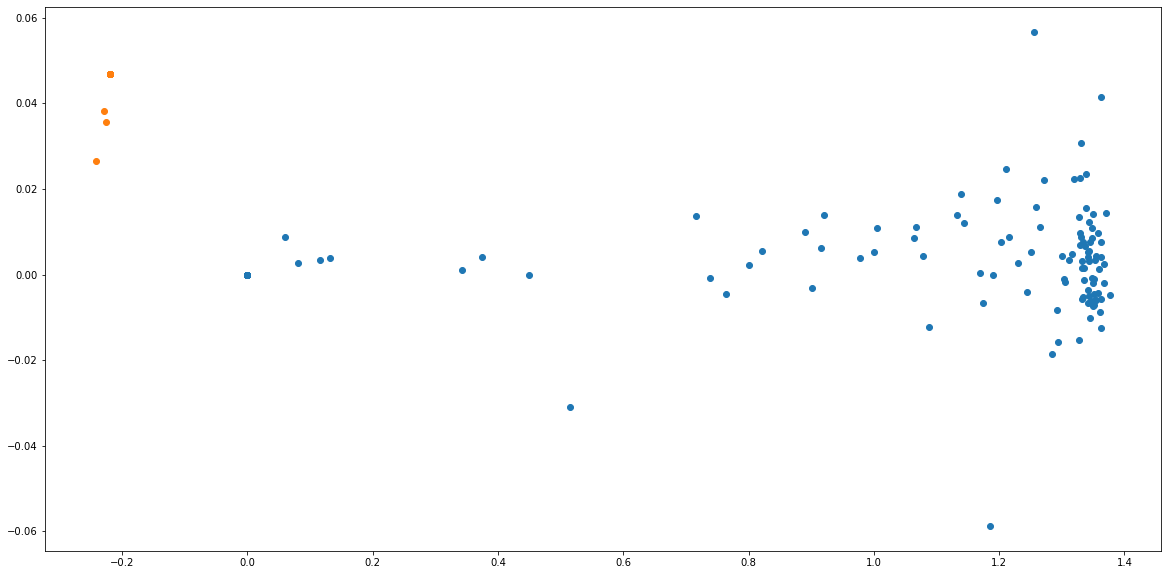

In [138]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(xtargets, ytargets)
ax.scatter(xpredictions, ypredictions)